In [6]:
import torch
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical
import utils.sde_lib as SDEs
import matplotlib.pyplot as plt

In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# class MultivariateGaussian():
#     def __init__(self, mean, cov):
#         super().__init__()
#         self.mean = mean
#         self.cov = cov
#         self.Q = torch.linalg.cholesky(self.cov)
#         self.inv_cov = torch.linalg.inv(cov)
#         self.L = torch.linalg.cholesky(self.inv_cov)
#         self.log_det = torch.log(torch.linalg.det(self.cov))
#         self.dist = torch.distributions.MultivariateNormal(self.mean,self.cov)
#         self.dim = mean.shape[0]
    
#     def sample(self):
#         # TODO: Make this in batches
#         return self.Q @ torch.randn_like(self.mean) + self.mean
    
#     def _log_prob(self,x):
#         from math import log, pi
#         new_shape = list(x.shape)
#         new_shape[-1] = 1
#         new_shape = tuple(new_shape)
#         x = x.view((-1,self.dim))
#         shift_cov = (self.L.T @ (x-self.mean).T).T
#         log_prob = -.5 * ( self.dim * log(2 * pi) +  self.log_det + torch.sum(shift_cov**2,dim=1)) 
#         log_prob = log_prob.view(new_shape)
#         return log_prob

#     def _grad_log_prob(self, x):
#         # This is the gradient of p(x)
#         curr_shape = x.shape
#         x = x.view((-1,self.dim))
#         grad = - (self.inv_cov @ (x - self.mean).T).T
#         grad = grad.view(curr_shape)
#         return grad
  
  
class GMM():

    def __init__(self, means, var, weights) -> None:
        # Currently assuming the vars are Id
        self.n = means.shape[0]
        self.means = means
        self.vars = var
        self.weights = Categorical(weights)
        dists = MultivariateNormal(means, self.vars)
        self.dist = MixtureSameFamily(self.weights,dists)

    @property
    def sde(self):
        return self._sde
    
    @sde.setter
    def sde(self, sde):
        self._sde = sde

    def sample(self, n):
        return self.dist.sample((n,))

    def score(self, x, t,*args, **kwargs):
        mean_t, std = self.sde.marginal_prob(self.means,t[:self.n])
        dists = MultivariateNormal(mean_t, covariance_matrix=self.vars)
        dist = MixtureSameFamily(self.weights,dists)
        with torch.enable_grad():
            x_aux = x.detach().clone().requires_grad_(True)
            log_prob = dist.log_prob(x_aux)
            return torch.autograd.grad(log_prob.sum(), x_aux)[0] 
        

[]

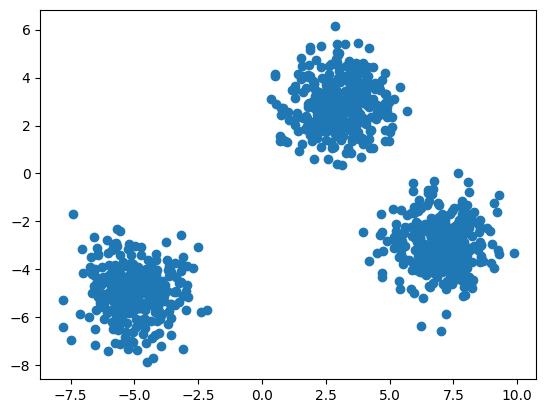

In [10]:
means = torch.tensor([[7.,-3.,0.,0.],[-5,-5.,0.,0.], [3.,3,0,0]], device=device)
vars = torch.tensor([[[1.,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],
                     [[1.,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],
                     [[1.,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]], device=device)
weights = torch.ones(3, device=device)/3

gmm =  GMM(means, vars, weights)

samples = gmm.sample(1000)
plt.scatter(samples[:,0].cpu(),samples[:,1].cpu())
plt.plot()

In [22]:
def score_cld(x,t, *args):
    score = gmm.score(x,t.reshape(-1,1))
    return score.chunk(2,dim=1)[1]

cld = SDEs.CLD(backward_model=score_cld)
gmm.sde = cld
samp, traj = cld.sample((100,4),device,prob_flow=True, return_traj=True,n_time_pts=100)

@torch.no_grad()
def measure_straightness(sde, trajectories):
    start, end = trajectories[:,0], trajectories[:,-1]
    diff = end - start
    straightness = 0
    n_pts =trajectories.shape[1]
    dt = sde.T/n_pts

    time_pts = sde.T - torch.linspace(0., sde.T, n_pts, device=device)
    one = torch.ones(start.shape[0],device=start.device)
    for i in range(n_pts-1):
        drift = sde.probability_flow_drift(trajectories[:,i+1], one * (time_pts[i]))
        val = diff-drift
        # val = val[:,:2]
        straightness += torch.mean(torch.sum((val)**2,dim=-1),dim=0)
    
    return straightness * dt #/(trajectories.shape[-1])



def plot_lines(traj, dim1,dim2,filename):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    ax.grid(True, linestyle='--', linewidth=0.5)
    for i in range(traj.shape[0]):
        xi = traj[i]
        ax.plot(xi[:,dim1].cpu(), xi[:,dim2].cpu(), linewidth=1, alpha=.3)

    # ax.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(), label='start',zorder=1010, cmap='viridis', s=10, alpha=0.75)
    ax.scatter(traj[:,-1:,dim1].cpu(), traj[:,-1,dim2].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
    ax.set_xlim(traj[...,dim1].cpu().min()-0.5, traj[...,dim1].cpu().max()+0.5)
    ax.set_ylim(traj[...,dim2].cpu().min()-0.5, traj[...,dim2].cpu().max()+0.5)

    ax.legend()
    fig.savefig(filename,facecolor='none', edgecolor='none', transparent=True)
    plt.close(fig)
    
plot_lines(traj,1,3,'trajectory/lines_gmm.png')
measure_straightness(cld, traj)

/tmp/ipykernel_24647/839084276.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(traj[:,-1:,dim1].cpu(), traj[:,-1,dim2].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)


tensor(227.3217, device='cuda:0')

[]

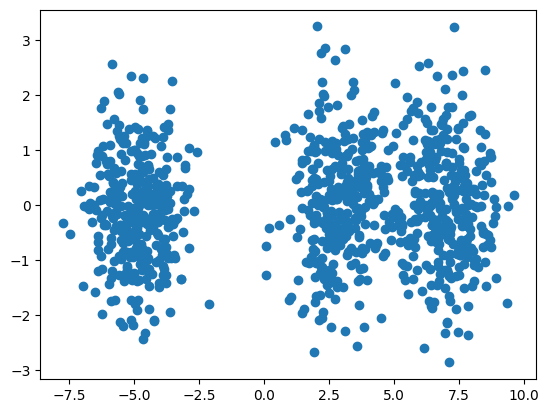

In [23]:
means = torch.tensor([[7.,0.],[-5,0.], [3.,0]], device=device)
vars = torch.tensor([[[1.,0],[0,1]],
                     [[1.,0,],[0,1]],
                     [[1.,0,],[0,1]]], device=device)
weights = torch.ones(3, device=device)/3

gmm =  GMM(means, vars, weights)

samples = gmm.sample(1000)
plt.scatter(samples[:,0].cpu(),samples[:,1].cpu())
plt.plot()

In [26]:

def score_cld(x,t, *args):
    score = gmm.score(x,t.reshape(-1,1))
    return score.chunk(2,dim=1)[1]

cld = SDEs.CLD(backward_model=score_cld)
gmm.sde = cld
samp, traj = cld.sample((100,2),device,prob_flow=True, return_traj=True,n_time_pts=100)

    
plot_lines(traj,0,1,'trajectory/lines_1d_gmm_phase.png')
measure_straightness(cld, traj)

/tmp/ipykernel_24647/839084276.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(traj[:,-1:,dim1].cpu(), traj[:,-1,dim2].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)


tensor(115.0544, device='cuda:0')

In [1]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
dataset_recipes.keys()

dict_keys(['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_without_missi